# DTMC

In [9]:
from switss.model import DTMC
import numpy as np
from switss.utils import color_from_hash

# setup the graph
# ----------------
E = [[0,1],[1,2],[2,0],[3,2],[3,1],[3,5],[4,2],[4,6],[5,4],[5,3],[6,4],[7,5],[7,6],[7,7]]
P = np.zeros(shape=(8,8))
for u,v in E:
    # initialize with arbitrary probabilities
    ucount = len([w for w,z in E if w == u])
    P[u,v] = 1/ucount
# ----------------

# create DTMC
dtmc = DTMC(P)

print("Transitions:")
print(dtmc.P)

Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (3, 1)	0.3333333333333333
  (3, 2)	0.3333333333333333
  (3, 5)	0.3333333333333333
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 3)	0.5
  (5, 4)	0.5
  (6, 4)	1.0
  (7, 5)	0.3333333333333333
  (7, 6)	0.3333333333333333
  (7, 7)	0.3333333333333333


MEC amount: 6


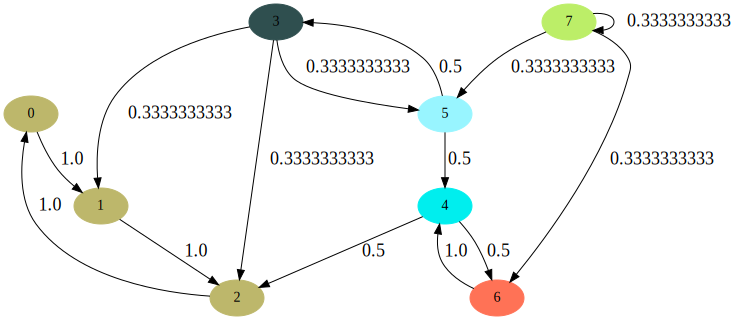

In [10]:
# using the example-DTMC above, we can retrieve its MECs.
components,proper_mecs,mec_counter = dtmc.maximal_end_components()
print("MEC amount:", mec_counter)

def sm(stateidx,labels):
    color = color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

dtmc.digraph(state_map=sm)

# MDP

In [11]:
from switss.model import MDP
import numpy as np
from switss.utils import color_from_hash

# setup the graph
# ----------------
SAPpairs = [(2,0,1,0.7),(0,0,1,1),(1,0,2,1),(2,0,0,0.3),(3,0,2,1),(4,0,2,0.5),(3,1,5,1),(5,1,3,1),(5,0,4,1),(4,0,6,0.5),(6,0,4,1),(7,1,6,0.5),(7,1,5,0.5),(7,0,7,1)]
index_by_state_action = {(0,0):0,(1,0):1,(2,0):2,(3,0):3,(4,0):4,(3,1):5,(5,1):6,(5,0):7,(6,0):8,(7,1):9,(7,0):10}
P = np.zeros(shape=(11,8))
for s,a,d,p in SAPpairs:
    P[index_by_state_action[(s,a)],d] = p
# ----------/------

mdp = MDP(P,index_by_state_action)


In [12]:
print("Index by state action:\n (from_state, action) <-> code")
for (from_state, action), code in mdp.index_by_state_action.items():
    print(f'({from_state}, {action}) <-> {code}') 
print('\n')

print("Transitions:")
print(mdp.P)

Index by state action:
 (from_state, action) <-> code
(0, 0) <-> 0
(1, 0) <-> 1
(2, 0) <-> 2
(3, 0) <-> 3
(4, 0) <-> 4
(3, 1) <-> 5
(5, 1) <-> 6
(5, 0) <-> 7
(6, 0) <-> 8
(7, 1) <-> 9
(7, 0) <-> 10


Transitions:
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 0)	0.3
  (2, 1)	0.7
  (3, 2)	1.0
  (4, 2)	0.5
  (4, 6)	0.5
  (5, 5)	1.0
  (6, 3)	1.0
  (7, 4)	1.0
  (8, 4)	1.0
  (9, 5)	0.5
  (9, 6)	0.5
  (10, 7)	1.0


MEC amount: 5


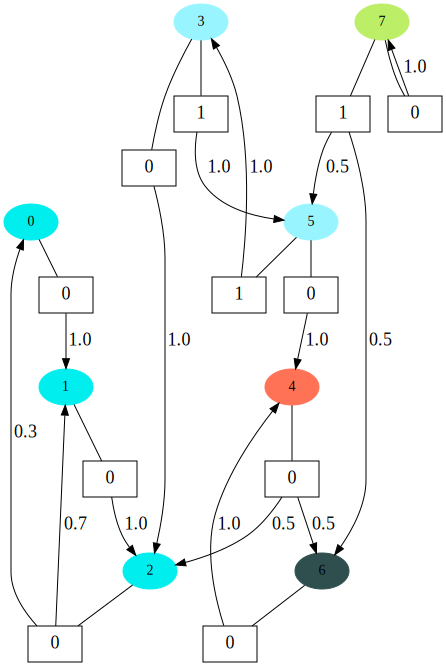

In [13]:
components,proper_mecs,mec_counter = mdp.maximal_end_components()
print("MEC amount:", mec_counter)

def sm(stateidx,labels):
    color = color_from_hash(7*components[stateidx])
    return { "color" : color, "style" : "filled" } 

mdp.digraph(state_map=sm)

In [14]:
q_mdp = mdp.mec_quotient_mdp(components, proper_mecs, mec_counter)

Component members:
Component 0 = A: [7]
Component 1 = B: [3, 5]
Component 2 = C: [6]
Component 3 = D: [4]
Component 4 = E: [0, 1, 2]


Index by state action:
 (from_component, q_action = original mdp action code) <-> q_code
(A, 11) <-> 0
(B, 11) <-> 1
(E, 11) <-> 2




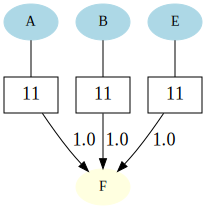

In [15]:
component_members = {}
for vertex, component in enumerate(components):
    if component not in component_members:
        component_members[component] = []
    component_members[component].append(vertex)

print("Component members:")
for compidx in range(mec_counter):
    print(f'Component {compidx} = {chr(ord('A') + compidx)}:', component_members[compidx])
print('\n')

print("Index by state action:\n (from_component, q_action = original mdp action code) <-> q_code")
for (from_comp, action), code in q_mdp.index_by_state_action.items():
    print(f'({chr(ord('A') + from_comp)}, {action}) <-> {code}') 
print('\n')

def sm(compidx,labels):
    if compidx == mec_counter:
        color = "lightyellow"
    elif proper_mecs[compidx] == 1:
        color = "lightblue"
    else:
        color = "pink"
    return { "color" : color, "style" : "filled", "label" : chr(ord('A') + compidx) } 

### lightyellow component is an exit; lighblue components are proper end components
q_mdp.digraph(state_map=sm)

In [16]:
q_A = q_mdp.get_system_matrix()

print(q_A)

[[ 1. -0. -0. -0. -0. -1.]
 [-0.  1. -0. -0. -0. -1.]
 [-0. -0. -0. -0.  1. -1.]]
